<a href="https://colab.research.google.com/github/Agniva2006/Gender-Classification-Deep-Learning-Model/blob/main/Task_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gender Classification Project

## 1.google drive permision check

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.Import zip file from drive

In [2]:
import zipfile

zip_path = "/content/drive/MyDrive/Comys_Hackathon5.zip"
extract_path = "/content/Comys_Hackathon5"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

## 3.Import the libraries

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms,models,datasets
from torchvision.transforms import ToTensor, Normalize, Resize, Compose, RandomHorizontalFlip, ColorJitter
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## 4.HyperParaMeters

In [4]:
BATCH_SIZE = 32
LR = 1e-4
EPOCHS = 5
IMAGE_SIZE = 224

## 5.Data Transforms

In [5]:
train_transform=transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform=transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

##6. Find The Directories Of Train and Validation Datasets

In [6]:
!find /content/Comys_Hackathon5/ -name "train"
!find /content/Comys_Hackathon5/ -name "val"

/content/Comys_Hackathon5/Comys_Hackathon5/Task_A/train
/content/Comys_Hackathon5/Comys_Hackathon5/Task_B/train
/content/Comys_Hackathon5/Comys_Hackathon5/Task_A/val
/content/Comys_Hackathon5/Comys_Hackathon5/Task_B/val


## 7.breakdown into train and test datasets

In [7]:
train_dataset = datasets.ImageFolder("/content/Comys_Hackathon5/Comys_Hackathon5/Task_A/train", transform=train_transform)
val_dataset = datasets.ImageFolder("/content/Comys_Hackathon5/Comys_Hackathon5/Task_A/val", transform=val_transform)

## 8. length of training dataset

In [8]:
len(train_dataset)

1926

## 9. assigned male as 1 and female as 0

In [9]:
from collections import Counter

targets = [label for _, label in train_dataset]
class_counts = Counter(targets)

print(class_counts)


Counter({1: 1623, 0: 303})


## 10. Create Weights For each Sample

In [10]:
import numpy as np
from torch.utils.data import WeightedRandomSampler

class_sample_counts = [class_counts[0], class_counts[1]]
weights = 1. / np.array(class_sample_counts)

sample_weights = [weights[label] for label in targets]


## 11.initialize the weightRandomSampler

In [11]:
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)


## 12. load the DataLoader

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler,num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 13. use the gpu

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 14. use of pretrained Model (RESNET18)

In [14]:
model = models.resnet18(pretrained=True)
#dropout
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.fc.in_features, 2)
)

model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 14. Optimizaor and criterion

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

## 15 .Training the dataset

In [16]:
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(EPOCHS):
    # -------------------- Training --------------------
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_losses.append(train_loss / total)
    train_accuracies.append(train_acc)

    # -------------------- Validation --------------------
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = 100 * correct / total
    val_losses.append(val_loss / total)
    val_accuracies.append(val_acc)

    # -------------------- Print Epoch Summary --------------------
    print(f"Epoch {epoch+1}/{EPOCHS}: "
          f"Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}, "
          f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")


Epoch 1/5: Train Loss=0.2086, Val Loss=0.2176, Train Acc=90.39%, Val Acc=91.94%
Epoch 2/5: Train Loss=0.0781, Val Loss=0.2084, Train Acc=97.35%, Val Acc=91.94%
Epoch 3/5: Train Loss=0.0400, Val Loss=0.3056, Train Acc=98.65%, Val Acc=90.52%
Epoch 4/5: Train Loss=0.0229, Val Loss=0.3058, Train Acc=99.53%, Val Acc=91.71%
Epoch 5/5: Train Loss=0.0257, Val Loss=0.2770, Train Acc=99.33%, Val Acc=91.94%


## 16.Classification Matrix

In [17]:
print("Final Validation Metrics (Task A - Gender Classification):")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

Final Validation Metrics (Task A - Gender Classification):
              precision    recall  f1-score   support

      female       0.81      0.75      0.78        79
        male       0.94      0.96      0.95       343

    accuracy                           0.92       422
   macro avg       0.88      0.85      0.86       422
weighted avg       0.92      0.92      0.92       422



## 17. Accuracy Matrices

In [18]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels, all_preds)
print(f" Validation Accuracy: {accuracy * 100:.2f}%")

 Validation Accuracy: 91.94%


In [19]:
from sklearn.metrics import roc_auc_score
roc_auc_score(all_labels, all_preds)

np.float64(0.8530095582536812)

In [20]:
from sklearn.metrics import classification_report

model.eval()
train_preds, train_labels = [], []

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu()
        train_preds.extend(preds)
        train_labels.extend(labels)

# Report
print("🔍 Classification Report (Training Set):")
print(classification_report(train_labels, train_preds, target_names=train_dataset.classes))


🔍 Classification Report (Training Set):
              precision    recall  f1-score   support

      female       0.99      1.00      1.00      1015
        male       1.00      0.99      1.00       911

    accuracy                           1.00      1926
   macro avg       1.00      1.00      1.00      1926
weighted avg       1.00      1.00      1.00      1926



## code testing

# upload image of mbappe

In [21]:
from google.colab import files
uploaded = files.upload()


Saving mbappe.png to mbappe.png


# prepare the image

In [22]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Replace with the name of the uploaded image
image_path = list(uploaded.keys())[0]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # standard ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

img = Image.open(image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)


# evaluation

In [23]:
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)
    class_idx = predicted.item()
    class_names = train_dataset.classes  # ['female', 'male'] from your original dataset

print(f"Predicted Gender: {class_names[class_idx]}")


Predicted Gender: male


# showing

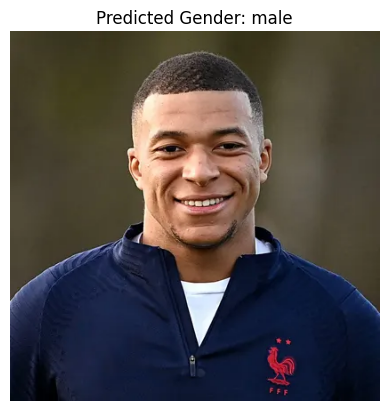

In [24]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(f"Predicted Gender: {class_names[class_idx]}")
plt.axis('off')
plt.show()


In [25]:
MODEL_PATH = "/content/gender_model.pth"
torch.save(model.state_dict(), MODEL_PATH)
print("Model saved to:", MODEL_PATH)

Model saved to: /content/gender_model.pth
